# NMT using Encoder Decoder Model - End to End Pipeline



## Data:

* We are going to use dataset from the below link.
* The dataset is "Tab-delimited Bilingual Sentence Pairs" and present from one natural language to another natural language.
http://www.manythings.org/anki/

* We are going to use French to English Sentence Pairs to train and test the Deep Learning Models.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import pickle
import zipfile
import datetime
import unicodedata

import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# os.chdir("/content/drive/MyDrive/neural_machine_translation")

In [2]:
# clear any logs from previous runs
!rm -rf ./logs/

# loading TensorBoard
%load_ext tensorboard


## 2. Import Data

In [3]:
## extracting details from the text file
with open("/content/drive/MyDrive/neural_machine_translation/fra.txt", "r",
          encoding="utf8") as f:
    text = f.readlines()

print("total sentences present in the text file is",len(text))
print(text[45600])

total sentences present in the text file is 190206
You chose a good one.	Vous en avez choisi un bon.	CC-BY 2.0 (France) Attribution: tatoeba.org #3168058 (CK) & #5939220 (Aiji)



* As we can see the file has many junk values other than translations.
* We need only sentences here in different list files.

In [4]:
## extracting both english and french text from the text file
sentences = [[sent.split("\t")[0], sent.split("\t")[1]] for sent in text]

## creating a dataframe
df = pd.DataFrame(sentences, columns=["English", "French"])

### getting the length of the words of each sentence
df["french_length"] = df['French'].str.split().apply(len)
df["english_length"] = df['English'].str.split().apply(len)

## sample
df.sample(2)

,English,French,french_length,english_length
163815,You should be careful in choosing friends.,Tu devrais être prudent dans le choix de tes a...,10,7
84089,I don't have a white shirt.,Je n'ai pas de chemise blanche.,6,6


## 3. Text Preprocessing

### 3.1 box plot to check the distribution of the sentences having unique words

In [5]:
def box_plot_analysis(data, size, num_row, num_col, columns):
    """
    This function is to plot box plot for numerical features.
    """
    figure = plt.figure(figsize=size) ## setting up the size
    col_num = 1  ## starting the column number from 1
    ## iterating over column names
    for i in columns:
        plt.subplot(num_row, num_col, col_num) ## creating subplots
        plot = sns.boxplot(data[i])  ## boxplot
        plt.xlabel(i, fontsize=12)   ## column label
        col_num += 1
    return plt.show()

A quick check to find columns that contain outliers, graphical
------------------------------------------------------------------------------------------------------------------------


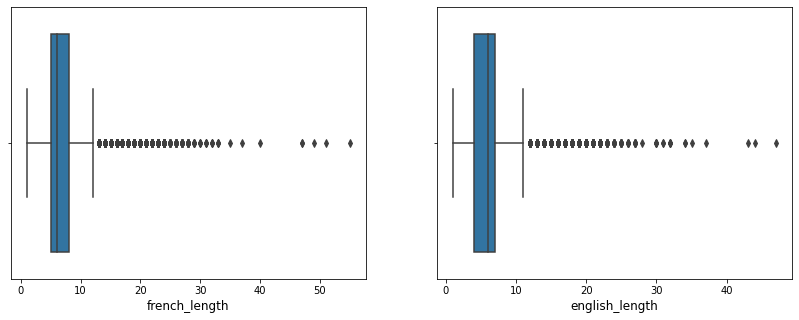

In [6]:
# A quick check to find columns that contain outliers
print('A quick check to find columns that contain outliers, graphical'); print('--'*60)

box_plot_analysis(df, (14,5), 1, 2, df.columns[-2:])

- It seems both french and english sentences has an upper fence around 12. That means sentence having more than 12 words here considered as an outlier.

### 3.2 percentile analysis

In [7]:
## getting percentile of each length at different values
df.describe([0.25,0.50,0.75,0.90,0.95,0.99, 0.999]).transpose()

,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
french_length,190206.0,6.637157,2.828913,1.0,5.0,6.0,8.0,10.0,12.0,16.0,22.0,55.0
english_length,190206.0,6.085413,2.527687,1.0,4.0,6.0,7.0,9.0,11.0,14.0,20.0,47.0


- Both english and french sentences has 99.9% of its input sentence having less or equal to 22 words.

In [8]:
## keeping the threshold of words for each sentence as 22 and removing the sentences where words are more than 22
threshold = 22
modified_df = df[(df["french_length"] <= threshold) & (df["english_length"] <= threshold)]
print("shape of the cleaned dataframe",modified_df.shape)

shape of the cleaned dataframe (190018, 4)


## 4. Splitting of Data

In [9]:
from sklearn.model_selection import train_test_split
xtrain, xval = train_test_split(modified_df, 
                                test_size=0.05) ## keeping test size as 20%

# ## bifurcating english and french sentences into train and test datasets
xtrain_eng = list(xtrain["English"].values); xval_eng = list(xval["English"].values)
xtrain_fre = list(xtrain["French"].values); xval_fre = list(xval["French"].values)

## 5 Teacher Forcing

* Teacher forcing is a common technique used in Neural Machine Translation.
* It is a method for quickly and efficiently training recurrent neural network models that use the ground truth from
  a prior time step as input.
* There are sequence prediction models that use the output from the last time step y(t-1) as input for the model at the
  current time step X(t).
* Let us consider the example data point

<pre>
    In French: Nous nous sommes accordés sur un prix.
    English Input to the model:    &lt;start>   We agreed on a price	
                                             |     |    | |   |
    English Input from the model:            We agreed on a price	&lt;end>
</pre>

1. If we observe the sentences, the start token is getting mapped to the first word in your english sentence, the first word is mapped to 2nd word, the 2nd word mapped to 3rd word and so on, finall the last one will is mapped to end token. i.e i the word will be mapped to i+1th word.

2. As we will be passing "english_inp" as an input to the decoder and the outputs(predictions) of the decoder will be compared against the "english_out"

3. With this way of mapping, we can ensure that the model will predict the next word and calculate the loss accordingly.

In [10]:
def unicode_to_ascii(sentence):
    """
    This function converts unicode into ascii format.
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', sentence)
        if unicodedata.category(c) != 'Mn')


def preprocessing(sentence):
    """
    This function normalizes the string by doing preprocessing.
    """
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r'([!.?])', r' \1', sentence)  #removing special character
    sentence = re.sub(r'[^a-zA-Z.!?]+', r' ',sentence) #keeping only letters and words
    sentence = re.sub(r'\s+', r' ', sentence)  #removing extra spaces to avoid treating as a sentence
    return sentence

In [11]:
#normalize string for train data
xtrain_french = [preprocessing(sent) for sent in xtrain_fre]
xtrain_eng_in = ['<start> ' + preprocessing(sent) for sent in xtrain_eng]
xtrain_eng_out = [preprocessing(sent) + ' <end>' for sent in xtrain_eng]

#normalize string for validation data
xval_french = [preprocessing(sent) for sent in xval_fre]
xval_english = [preprocessing(sent) for sent in xval_eng]

In [12]:
pickle.dump(xtrain_eng_in, open("train_english_in.lst", 'wb'))
pickle.dump(xtrain_eng_out, open("train_english_out.lst", 'wb'))
pickle.dump(xval_english, open("validation_english.lst", 'wb'))
pickle.dump(xtrain_french, open("train_french.lst", 'wb'))
pickle.dump(xval_french, open("validation_french.lst", 'wb'))

## 6. Tokenization

* Tokenization is a common task in Natural Language Processing (NLP).
* It is a way of separating a piece of text into smaller units called tokens. 
* Here, tokens can be either words, characters, or subwords.

In [13]:
#Tokenizing data with no filters and fitting it with french data
fre_token = Tokenizer(filters='')
fre_token.fit_on_texts(xtrain_french)  
fra_train_tkn = fre_token.texts_to_sequences(xtrain_french)

In [14]:
#Tokenizing data with no filters and fitting it with english data
eng_token = Tokenizer(filters='')

eng_token.fit_on_texts(xtrain_eng_in)
eng_token.fit_on_texts(xtrain_eng_out)

eng_train_in_tkn = eng_token.texts_to_sequences(xtrain_eng_in)
eng_train_out_tkn = eng_token.texts_to_sequences(xtrain_eng_out)

In [15]:
## dumping tokens as a pickle file
pickle.dump(eng_token, open("english_tokens.tkn", 'wb'))
pickle.dump(fre_token, open("french_tokens.tkn", 'wb'))

## 7. Sequence Padding

* When we pre-process the texts and use the texts as an inputs for our Model.
* Note that not all the sequences have the same length, as we can say naturally some of the sequences are long in lengths and some are short. 
* Where we know that we need to have the inputs with the same size, now here padding comes into picture. 
* The inputs should be in same size at that time padding is necessary.

In [16]:
# post padding means adding 0's after sentence
xtrain_fre_pad = pad_sequences(fra_train_tkn, maxlen = threshold, dtype='int32', padding='post') 
xtrain_eng_pad_in = pad_sequences(eng_train_in_tkn, maxlen = threshold, dtype='int32', padding='post')
xtrain_eng_pad_out = pad_sequences(eng_train_out_tkn, maxlen = threshold, dtype='int32', padding='post')

In [17]:
## getting vocabulary size
vocab_fre = len(fre_token.word_index.keys()) + 1
vocab_eng = len(eng_token.word_index.keys()) + 1

vocab_fre, vocab_eng

(23472, 14530)

## 8. Callbacks

* A callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference.

In [18]:
## Tensorboard
log_directory = "callback/TensorBoard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir = log_directory, histogram_freq=1,  write_graph=True, write_grads=False)

## Early Stopping
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=2, restore_best_weights=True)

# 9. encoder decoder model using model subclassing

### 9.1 model architecture

In [19]:
class Encoder(tf.keras.Model):
        
    '''Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c'''
    
    def __init__ (self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.inp_vocab_size, 
                                   output_dim=self.embedding_size, 
                                   input_length=self.input_length,
                                   mask_zero=True, 
                                   name="embedding_layer_encoder")
        #Intialize Encoder LSTM layer
        self.lstm = LSTM(self.lstm_size, 
                         return_state=True, 
                         return_sequences=True, 
                         name="Encoder_LSTM")

    def call(self,input_sequence,*kwargs):

        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
    
    def initialize_states(self,batch_size):
        
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.batch_size = batch_size
        state_h = tf.zeros((batch_size,self.lstm_size))
        state_c = tf.zeros((batch_size,self.lstm_size))
        initial_states = [state_h, state_c]
        return initial_states 

In [20]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
      
        #Initialize Embedding layer
        self.embedding = Embedding(input_dim=out_vocab_size,
                                   output_dim=embedding_size,
                                   input_length=input_length,
                                   mask_zero=True,
                                   name="embedding_layer_decoder")
        #Intialize Decoder LSTM layer
        self.lstm = LSTM(self.lstm_size, 
                         return_sequences=True, 
                         return_state=True, 
                         name="Encoder_LSTM")


    def call(self,input_sequence,initial_states,*kwargs):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
        returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
      '''
        target_embedd = self.embedding(input_sequence)
        decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(target_embedd, 
                                                                                 initial_state = initial_states)
        return decoder_output, decoder_final_state_h, decoder_final_state_c
      

In [21]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, encoder_inputs_length, decoder_inputs_length, 
                 input_vocab_size, output_vocab_size, 
                 emb_size, lstmsize):
        
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = input_vocab_size,
                               embedding_size = emb_size, 
                               input_length = encoder_inputs_length, 
                               lstm_size = lstmsize)
        
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = output_vocab_size, 
                               embedding_size = emb_size, 
                               input_length = decoder_inputs_length, 
                               lstm_size = lstmsize)
        
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(output_vocab_size, 
                           activation='softmax')
    
    
    def call(self,data, *kwargs):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input_sequence, output_sequence = data[0], data[1]
        encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(input_sequence,*kwargs)
        initial_states = [encoder_final_state_h, encoder_final_state_c]
        decoder_output,_,_ = self.decoder(output_sequence, initial_states)
        output = self.dense(decoder_output)

        return output

### 9.2 model setup and training

In [22]:
clear_session()

epoch = 100
embsize = 128
batchsize = 1024
lstm_size = 512
threshold = 22
    
#create an object of encoder_decoder Model class, 
model  = Encoder_decoder(encoder_inputs_length = threshold, decoder_inputs_length = threshold, 
                         input_vocab_size = vocab_fre, output_vocab_size = vocab_eng,
                         emb_size = embsize, lstmsize = lstm_size)

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy') #compile the model

In [23]:
%%time
history = model.fit([xtrain_fre_pad, xtrain_eng_pad_in], xtrain_eng_pad_out,
                    batch_size = batchsize, epochs=250, 
                    callbacks = [tensorboard, earlystop])

# dumping weights into h5 files
model.save_weights('enc_dec_weights.h5')

Epoch 1/250
177/177 [==============================] - 20s 55ms/step - loss: 2.0262
Epoch 2/250
177/177 [==============================] - 10s 54ms/step - loss: 1.6023
Epoch 3/250
177/177 [==============================] - 10s 54ms/step - loss: 1.3471
Epoch 4/250
177/177 [==============================] - 10s 54ms/step - loss: 1.2121
Epoch 5/250
177/177 [==============================] - 10s 54ms/step - loss: 1.1021
Epoch 6/250
177/177 [==============================] - 10s 54ms/step - loss: 1.0117
Epoch 7/250
177/177 [==============================] - 10s 54ms/step - loss: 0.9302
Epoch 8/250
177/177 [==============================] - 10s 54ms/step - loss: 0.8534
Epoch 9/250
177/177 [==============================] - 10s 54ms/step - loss: 0.7818
Epoch 10/250
177/177 [==============================] - 10s 54ms/step - loss: 0.7179
Epoch 11/250
177/177 [==============================] - 10s 54ms/step - loss: 0.6593
Epoch 12/250
177/177 [==============================] - 10s 55ms/step - lo

### 9.3 model summary

In [24]:
print(model.summary())

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4317184   
                                                                 
 decoder (Decoder)           multiple                  3172608   
                                                                 
 dense (Dense)               multiple                  7453890   
                                                                 
Total params: 14,943,682
Trainable params: 14,943,682
Non-trainable params: 0
_________________________________________________________________
None


### 9.4 model validation against loss plot

In [25]:
def loss_plot(data):
    """This function plots the loss graph."""
    plt.figure(figsize = (15,5))
    plt.plot(range(1,len(data)+1),data)
    plt.title("log loss", fontsize=15)
    plt.xlabel("epochs"); plt.ylabel("loss values")
    return plt.show()

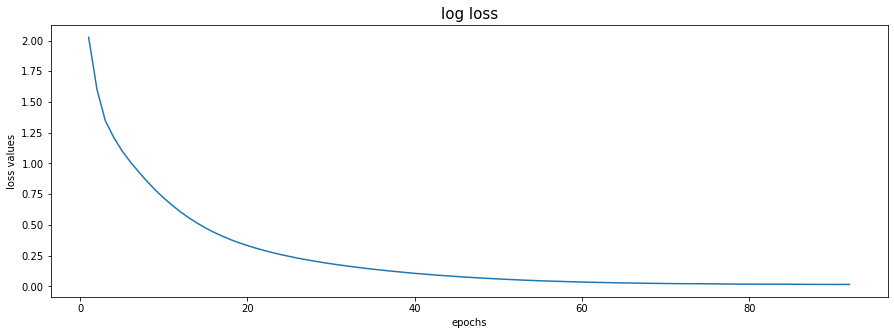

In [26]:
loss_plot(history.history["loss"])

## 10. Prediction Function

In [27]:
def predict(input_sentence, max_len, model, fra_token, eng_token):
    """
    This function takes an input sentence and predicts the tranlated output.
    """

    batch_size = 1
    inp_text_seq = input_sentence

    #given input sentence, convert the sentence into integers using tokenizer used earlier
    tokenize_text_data = fra_token.texts_to_sequences([inp_text_seq])
    sequenced_text_data = pad_sequences(tokenize_text_data, 
                                        maxlen=max_len, 
                                        dtype='int32', 
                                        padding='post')

    #Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    initial_states = model.layers[0].initialize_states(batch_size)
    encoder_outputs, state_h, state_c = model.layers[0](tf.constant(sequenced_text_data), initial_states)

    #Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    #till we reach max_length of decoder or till the model predicted word <end>:
    decoder_input = tf.expand_dims([eng_token.word_index["<start>"]],0)
    out_words = list()
    states = [state_h, state_c]
    while True:
        decoder_output, decoder_state_h, decoder_state_c = model.layers[1](decoder_input, states)
        decoder_output = model.layers[2](decoder_output)
        decoder_input = tf.argmax(decoder_output, -1)

        out_words.append(eng_token.index_word[decoder_input.numpy()[0][0]])
        if out_words[-1] == "<end>":
            out_words.remove("<end>")
            break
        
        #update the input_to_decoder with current predictions
        states = [decoder_state_h, decoder_state_c]
        decoder_input = tf.expand_dims([eng_token.word_index[eng_token.index_word[decoder_input.numpy()[0][0]]]],0)

    return (" ".join(out_words))

### 10.1 Predict Sentence

In [28]:
%%time
eng_sent_out = [predict(xval_french[num], threshold, model, fre_token, eng_token) for num in tqdm(range(0,len(xval_french)))]

100%|██████████| 9501/9501 [12:01<00:00, 13.16it/s]

CPU times: user 12min 41s, sys: 29.6 s, total: 13min 11s
Wall time: 12min 1s


## 10. BLEU Score

* The BLEU score is a string-matching algorithm that provides basic quality metrics for MT researchers and developers.

To conduct a BLEU measurement the following is necessary:

1. One or more human reference translations. This should be data that has not been used in building the system (training data) and ideally should be unknown to the MT system developer.
2. It is generally recommended that 1,000 or more sentences be used to get a meaningful measurement. Too small a sample set can sway the score significantly with just a few sentences that match or do not match well.
3. Automated translation output of the exact same source data set.
4. A measurement utility that performs the comparison and score calculation. ex: import nltk.translate.bleu_score as bleu

The BLEU metric scores a translation on a scale of 0 to 1, in an attempt to measure the adequacy and fluency of the MT output. The closer to 1 the test sentences score, the more overlap there is with their human reference translations and thus, the better the system is deemed to be. BLEU scores are often stated on a scale of 1 to 100 to simplify communication, but this should not be confused with the percentage of accuracy.

In [29]:
import random
from nltk.translate.bleu_score import sentence_bleu

score = sum([sentence_bleu([eng_sent_out[val]], xval_english[val].lower())
             for val in range(0, len(xval_english))])
print('BLEU score for Encoder Decoder Model is {:.4f}.'.format(score/len(xval_english)))

BLEU score for Encoder Decoder Model is 0.6770.
